In [44]:

from simulator.reporters import TransitionReporter
from simulator.core import Task
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from simulator import Config

In [45]:
def loadDataframe(batchId: str) -> pd.DataFrame:
    reportMap = None
    with open(
        "results/reportMaps/reportMap{id}.json".format(id = batchId),
        "r") as reportFile:
        reportMap = json.load(reportFile)
    
    # Finding all config changes
    configList = set()
    for report in reportMap:
        varients = report["varient"]
        for varient in varients:
            configList.add(varient["config"])
            
    tupleTemplate = {}
    for config in configList:
        tupleTemplate[config] = Config.get(config)
        tupleTemplate[config + "_default"] = True
    print(tupleTemplate)
    
    tupleList = []
    for report in reportMap:
        reportTupleTemplate = tupleTemplate.copy()
        runId = report["runId"]
        varients = report["varient"]
        for varient in varients:
            config = varient["config"]
            reportTupleTemplate[config] = varient["value"]
            reportTupleTemplate[config + "_default"] = False
        reportTupleTemplate["run_id"] = runId
        
        mobileReport = TransitionReporter.getListFromPickle("results/report/{batchId}/reportmobile{runId}.pkl".format(batchId = batchId, runId = runId))
        for item in mobileReport:
            tuple = reportTupleTemplate.copy()
            tuple["task_id"] = item.task.id()
            tuple["arrival_time"] = item.task.arrivalTime()
            tuple["delay"] = item.delay
            tuple["power"] = item.powerConsumtion
            tuple["reward"] = item.reward
            tuple["action"] = item.action
            tuple["hopLimit"] = item.task.hopLimit()
            tupleList.append(tuple)
            
    df = pd.DataFrame(tupleList)
    # unify action values
    df["action"] = df["action"].apply(lambda x: 0 if ("0" in str(x)) else (1 if ("1" in str(x)) else x))
    
    return df

In [57]:
df = loadDataframe("V3")

{'boxworld_centered_mobile_nodes': False, 'boxworld_centered_mobile_nodes_default': True, 'boxworld_mobile_nodes': 50, 'boxworld_mobile_nodes_default': True, 'edge_selector': 'dql', 'edge_selector_default': True, 'task_generator_lambda': 0.5, 'task_generator_lambda_default': True, 'mobile_selector': 'dql', 'mobile_selector_default': True}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


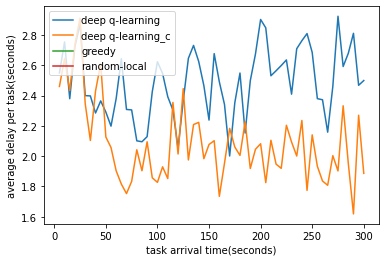

In [67]:
vairable_conditions = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "deep q-learning_c": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
condition =  (df["boxworld_mobile_nodes"] == 50) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["delay"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data)

plt.ylabel('average delay per task(seconds)')
plt.xlabel('task arrival time(seconds)')
plt.legend(graphs.keys(), loc='upper left')
plt.savefig('plots/delay_all_methods.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


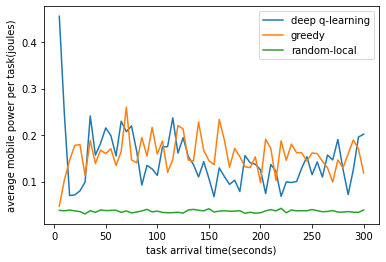

In [48]:
vairable_conditions = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
condition =  (df["boxworld_mobile_nodes"] == 50) & (df["task_generator_lambda"] == 0.75)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["power"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data)

plt.ylabel('average mobile power per task(joules)')
plt.xlabel('task arrival time(seconds)')
plt.legend(graphs.keys(), loc='upper right')
plt.savefig('plots/power_all_methods.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


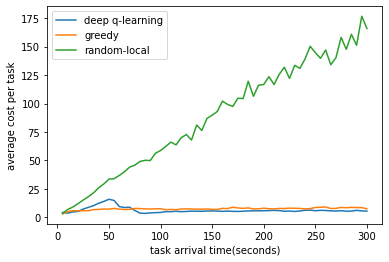

In [49]:
vairable_conditions = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data)

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend(graphs.keys(), loc='upper left')
plt.savefig('plots/reward_all_methods.eps', format='eps')

In [50]:
def barchartPlotter(values, valueLabels, classesLabel, yLabel, xLabel = None, legenLoc = None, savePath = None):
  labels = classesLabel
  x = np.arange(len(labels))  # the label locations
  width = 0.2  # the width of the bars
  fig, ax = plt.subplots()
  rects = []
  for i in range(0, len(values)):
    rects.append(ax.bar(x + (i - (len(values) - 1) / 2 ) * width, values[i], width, label=valueLabels[i]))
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(yLabel)
  ax.set_xlabel(xLabel)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  if legenLoc is None:  
    ax.legend()
  else:
    ax.legend(loc=legenLoc)
  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')
  #for i in range(0, len(values)):
  #  autolabel(rects[i])
  fig.tight_layout()
  
  if not (savePath is None):
    plt.savefig(savePath + '.eps', format='eps')
  plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


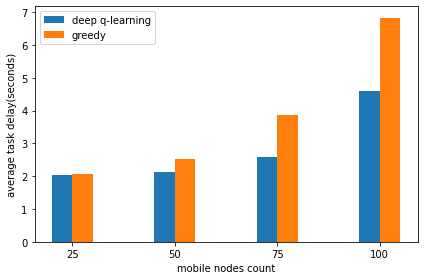

In [51]:
variable_conditions_method = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    #"random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["delay"]].mean()
        result.append(data["delay"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average task delay(seconds)", xLabel = "mobile nodes count", savePath = "plots/mobile_node_counts_delay")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


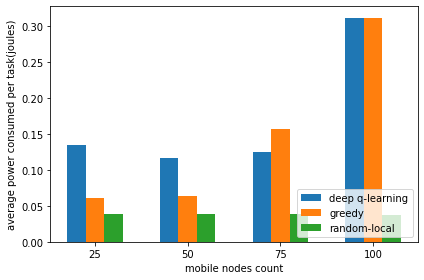

In [52]:
variable_conditions_method = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["power"]].mean()
        result.append(data["power"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average power consumed per task(joules)", xLabel = "mobile nodes count",
                 savePath = "plots/mobile_node_counts_power", legenLoc="lower right")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


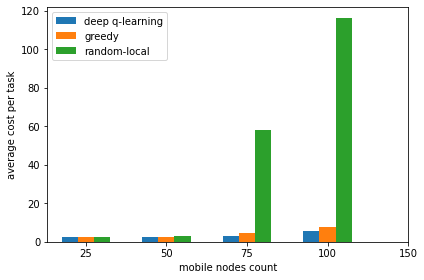

In [53]:
variable_conditions_method = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100),
    "150": (df["boxworld_mobile_nodes"] == 150)
}

condition = (df["task_generator_lambda"] == 0.5) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        result.append(data["reward"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average cost per task", xLabel = "mobile nodes count", savePath = "plots/mobile_node_counts_reward")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


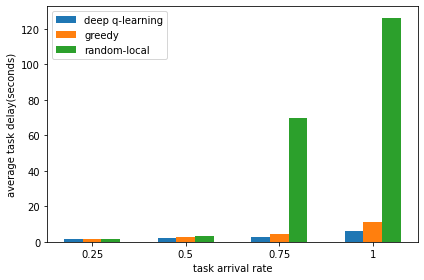

In [54]:
variable_conditions_method = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["delay"]].mean()
        result.append(data["delay"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average task delay(seconds)", xLabel = "task arrival rate", savePath = "plots/data_rate_delay")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


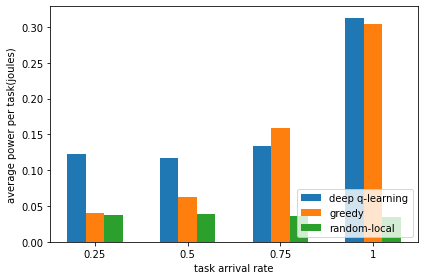

In [55]:
variable_conditions_method = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["power"]].mean()
        result.append(data["power"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average power per task(joules)", xLabel = "task arrival rate", savePath = "plots/data_rate_power", legenLoc="lower right")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


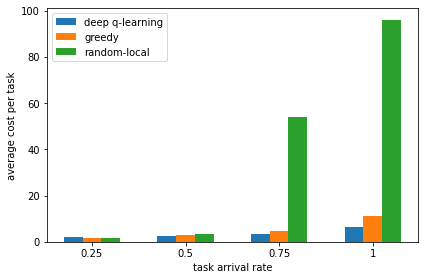

In [56]:
variable_conditions_method = {
    "deep q-learning": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local")
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        result.append(data["reward"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average cost per task", xLabel = "task arrival rate", savePath = "plots/data_rate_reward", legenLoc="upper left")